In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import torch
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid


sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})

<Figure size 432x288 with 0 Axes>

In [2]:
save_plots = False

## Load Data

In [3]:
###
#  construct a single dictionary from those of all the runs
###
def get_bo_res(which_results: str, nb_run: int, norm_type):
    assert "results" in which_results
    # initialize dict to store results 
    bo_res = pickle.load(open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, which_results, which_results, 0), 'rb'))
    for key in bo_res.keys():
        bo_res[key] = []
        
    # iterate though the runs
    for n in range(nb_run):
        # get results dict for specified run
        bo_res_file = pickle.load(
                        open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, which_results, which_results, n), 'rb'))
        
        # append results to end of list
        for key in bo_res_file.keys():
            key_res = bo_res_file[key]
            bo_res[key].append(key_res)
            
    return bo_res

In [4]:
###
#  features and molecular simulation data
###
file = h5py.File("targets_and_normalized_features.jld2", "r")

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) # ... Needs to be tensor?
# simulation data
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]

# total number of COFs in data set
nb_COFs = X.shape[0]

###
#  bayesian optimization data
###
# COF IDs used for initialization
init_cof_ids_file = pickle.load(open('search_results/min_max_normalization/initializing_cof_ids.pkl', 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids'][:10]

nb_COFs_initialization = len(init_cof_ids[0])
nb_runs = len(init_cof_ids)

# random search 
random_search_res = pickle.load(open('search_results/min_max_normalization/random_search_results.pkl', 'rb'))

# multi-fidelity search
mfbo_res = get_bo_res('mfbo_results', nb_runs, 'min_max_normalization')

# single-fideliy search
sfbo_res = get_bo_res('sfbo_results', nb_runs, 'min_max_normalization')

# number of iterations per run
nb_iters = len(mfbo_res['acquired_set'][0])

###
#  quick checks
###
# structure of data
assert len(sfbo_res['ids_acquired'][0]) == nb_iters
assert len(random_search_res['ids_acquired'][0]) == nb_iters
assert sfbo_res['nb_COFs_initialization'][0] == nb_COFs_initialization

# each run has the correct initializing COFs
assert all([
       all(sfbo_res['ids_acquired'][r][:nb_COFs_initialization] == init_cof_ids[r]) for r in range(nb_runs)])

## Search Efficientcy Curves

### Helper functions

In [5]:
def get_distribution(res, maxes=False):
    # initialize arrays for dist.
    mu      = np.zeros(nb_iters)
    sig_bot = np.zeros(nb_iters)
    sig_top = np.zeros(nb_iters)
    
    ###
    #  look at all runs and get the dist.
    ###
    for i in range(1, nb_iters+1):
        if maxes:
            # max value acquired up to this point (over all runs)       
            vals_at_iter = np.array([max(res[r][:i]) for r in range(nb_runs)])
        else:
            # make an arrey of all the values at a given iteration
            vals_at_iter = np.array([res[r][i-1] for r in range(nb_runs)])
        assert np.size(vals_at_iter) == nb_runs
        mu[i-1]      = np.mean(vals_at_iter)
        sig_bot[i-1] = np.std(vals_at_iter[vals_at_iter < mu[i-1]])
        sig_top[i-1] = np.std(vals_at_iter[vals_at_iter > mu[i-1]])
        
    return  mu, sig_bot, sig_top

### TEMP SECTION FOR ANALYSIS

In [6]:
# fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,8))

# iter_range = np.array(range(nb_iters))

# ax.plot(iter_range, sfbo_acc_cost_mu / 60, 
#            label=r"$\mu_{SFBO}$",
#            color="C0", linestyle="-")
# ax.fill_between(iter_range, 
#                    (sfbo_acc_cost_mu - sfbo_acc_cost_sig_bot) / 60, 
#                    (sfbo_acc_cost_mu + sfbo_acc_cost_sig_top) / 60, 
#                    alpha=0.65, color="C0")

# ax.plot(iter_range, mfbo_acc_cost_mu / 60, 
#            label=r"$\mu_{MFBO}$",
#            color="C1", linestyle="-")
# ax.fill_between(iter_range, 
#                    (mfbo_acc_cost_mu - mfbo_acc_cost_sig_bot) / 60, 
#                    (mfbo_acc_cost_mu + mfbo_acc_cost_sig_top) / 60, 
#                    alpha=0.65, color="C1")



# ###
# #  when, on average, is the top cof identifies
# ax.axvline(sfbo_mean_top_cof, label=r"avg. find $x^{\star}_{SFBO}$",
#            color="C0", linestyle=":")
# ax.axvline(mfbo_mean_top_cof, label=r"avg. find $x^{\star}_{MFBO}$",
#            color="C1", linestyle=":")



# ax.legend()
# ax.set_xlabel("# acquired COFs")
# ax.set_ylabel("accumulated cost [hr]")
# plt.show()

# Plots

In [7]:
###
#  when, on average, is the top COF located?
#  How many iterations do I need to include in the plot?
###
mfbo_mean_top_cof = np.mean(mfbo_res['BO_iter_top_cof_acquired'])

sfbo_mean_top_cof = np.mean(sfbo_res['BO_iter_top_cof_acquired'])

SFBO
2
148
MFBO
5
148


/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.p

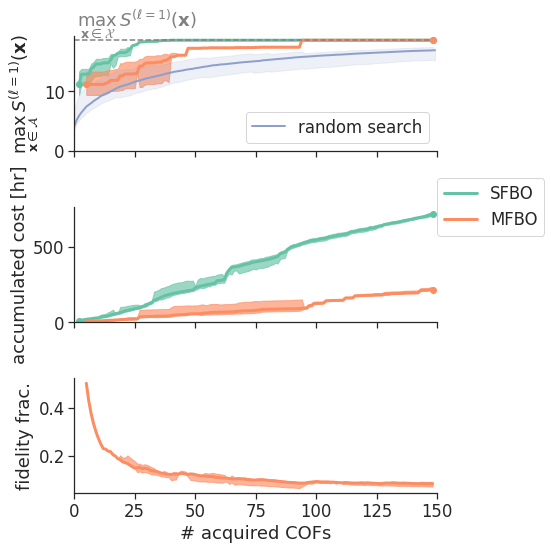

In [8]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))  
markers = dict({0 : '+', 1: 'x'})




for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) -1 # i + 1 is convenient hack :)
    print(iter_start)
#     iter_top_cof_acquired = int(np.ceil(np.mean(res['BO_iter_top_cof_acquired']))) # SFBO: 21, MFBO: 46
    iter_top_cof_acquired = nb_iters - 2
    print(iter_top_cof_acquired)
    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
    ###
    #  get distributions 
    ###
    # y_maxes
    y_max_mu, y_max_sig_bot, y_max_sig_top = get_distribution(res['y_max_acquired'], maxes=True)
    # accumulated_cost
    #  -----> TODO: convert to hours before saving dictionary!
    acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(res['accumulated_cost'])
    
    ###
    #  accumulated cost
    #     - index lags by 1
    ###
    ax[1].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               acc_cost_mu[iter_start:iter_top_cof_acquired+1] / 60, 
               label=search_type, 
               color=color)
    ax[1].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                       (acc_cost_mu[iter_start:iter_top_cof_acquired+1] - 
                                   acc_cost_sig_bot[iter_start:iter_top_cof_acquired+1]) / 60,
                       (acc_cost_mu[iter_start:iter_top_cof_acquired+1] + 
                                   acc_cost_sig_top[iter_start:iter_top_cof_acquired+1] ) / 60,
                       alpha=0.65, color=color)
    
    
    ax[1].scatter([iter_start], [acc_cost_mu[iter_start] / 60], color=color, marker="o")
    ax[1].scatter([iter_top_cof_acquired], [acc_cost_mu[iter_top_cof_acquired] / 60], 
                  color=color, marker="o")
    
    ###
    #  search efficiency curves
    ###    
    ax[0].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               y_max_mu[iter_start:iter_top_cof_acquired+1], 
#                label=r"$\mu_{SFBO}$",
               color=color, linestyle="-")
    ax[0].fill_between(iter_range[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] - 
                                       y_max_sig_bot[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] + 
                                       y_max_sig_top[iter_start:iter_top_cof_acquired+1],
                   alpha=0.65, color=color)
    # start and stop
    ax[0].scatter([iter_start], [y_max_mu[iter_start]], color=color, marker="o")
    ax[0].scatter([iter_top_cof_acquired], y_max_mu[iter_top_cof_acquired+1], 
                      color=color, marker="o", zorder=100)
#     if search_type == "MFBO":
#         fidelities = mfbo_res['acquired_set'][:, 0][iter_start:iter_top_cof_acquired+1] == 1
#         for f_id in [1]:
#             ax[0].scatter(iter_range[iter_start:iter_top_cof_acquired+1][fidelities], 
#                           y_max_at_iter[iter_start:iter_top_cof_acquired+1][fidelities], 
#                           color=color, marker=markers[f_id], zorder=100)
#             ax[1].scatter(iter_range[iter_start:iter_top_cof_acquired+1][fidelities], 
#                           acc_cost[iter_start:iter_top_cof_acquired+1][fidelities], 
#                           color=color, marker=markers[f_id], zorder=100)
    
    ###
    #  fidelity fraction
    ### 
    if search_type == "MFBO":
        # get dist.
        fid_frac_mu, fid_frac_sig_bot, fid_frac_sig_top = get_distribution(res['fidelity_fraction'])
        # plot
        ax[2].plot(iter_range[iter_start:iter_top_cof_acquired+1],
                   fid_frac_mu[iter_start:iter_top_cof_acquired+1], 
                   color=color)
        ax[2].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] - 
                                   fid_frac_sig_bot[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] + 
                                   fid_frac_sig_top[iter_start:iter_top_cof_acquired+1], 
                           alpha=0.65, color=color)


###
#  random search (SFBO, l=1)
###
ax[0].plot(range(len(random_search_res['y_rs_max_mu'])), random_search_res['y_rs_max_mu'], 
           label="random search", lw=2, color="C2")

ax[0].fill_between(range(len(random_search_res['y_rs_max_mu'])), 
                   random_search_res['y_rs_max_mu'] - random_search_res['y_rs_max_sig_bot'], 
                   random_search_res['y_rs_max_mu'] + random_search_res['y_rs_max_sig_top'], 
                   alpha=0.15, color="C2")

###  
#  global maximum
###
ax[0].axhline(y=max(y[1]), 
#               label=r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
              color="gray", ls="--", lw=1.5)
ax[0].text(1.0, max(y[1]) + 2.5, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
ax[0].set_xlim(xmin=0, xmax=nb_iters)
ax[0].set_ylim(ymin=0)
ax[0].set_ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, S^{(\ell=1)}(\mathbf{x})$')
ax[0].legend(loc='lower right')

ax[1].set_ylim(ymin=0)
ax[1].set_ylabel("accumulated cost [hr]")
ax[1].legend(loc=(1.0, 0.75))

ax[2].set_xlabel("# acquired COFs")
ax[2].set_ylabel("fidelity frac.")

plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/Cost_and_Search_Efficiency.pdf", format="pdf")
plt.show()

## Pirinciple Component Analysis

In [9]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

In [10]:
###
#  test point
###
a = torch.from_numpy(np.array([X[:, i].mean() for i in range(X.size()[1])]))
X_center = pca.transform(a.reshape(1, -1))
X_center

array([[-3.90109576e-18,  9.22603899e-18]])

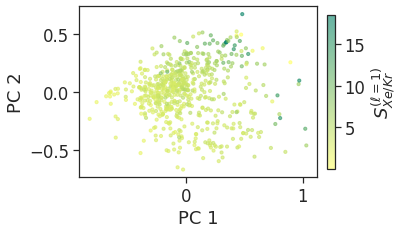

In [11]:
cmap_name = cm.summer_r # sequential colormaps: spring, summer, autumn, viridis, Wistia, hot, copper

fig = plt.figure()
#low dimensional (PCA) visualization of the entire dataset
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")
plt.xticks()
plt.yticks()

plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
if save_plots:
    plt.savefig("./figs/PCA_feature_space_colored_by_GCMC_Selectivity.pdf", dpi=600, format="pdf")
plt.show()

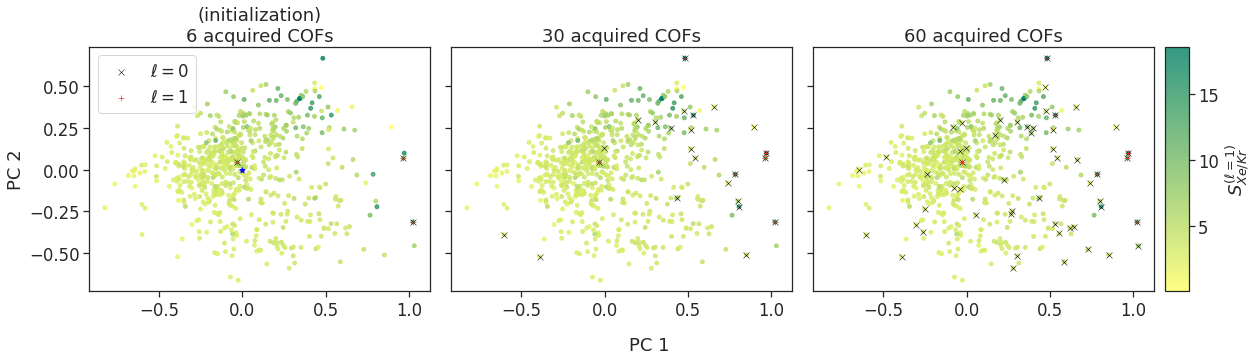

In [13]:
nb_acquired = [2*nb_COFs_initialization, 30, 60]

# set up figure and image grid
fig = plt.figure(figsize=[3*6.4 + 0.5, 4.8])

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1, 3),
                 axes_pad=0.3,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# add data to image grid
for (i, nb), ax in zip(enumerate(nb_acquired), grid):
    acq = mfbo_res['acquired_set'][0][:nb]
    lf_acq = acq[acq[:, 0] == 0, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == 1, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)
    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=15, alpha=0.8) 
    
    ### 
    # plot center of feature space and transformed point
    ###
    if i == 0:
        ax.scatter(X_center[:, 0], X_center[:, 1], color="b", marker="*", s=30)
        
    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax.scatter(X_2D[lf_acq[:nb, 1], 0], X_2D[lf_acq[:nb, 1], 1], 
                  label="$\ell=0$",
                  color='k', marker='x', s=35, lw=0.5) 
    # high-fidelity
    ax.scatter(X_2D[hf_acq[:nb, 1], 0], X_2D[hf_acq[:nb, 1], 1], 
               label="$\ell=1$",
               color='r', marker='+', s=35, lw=0.5, zorder=1)
    

    
    # subplot titles
    if i == 0:
        ax.set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax.set_title('{} acquired COFs'.format(nb_acquired[i]))
        
    ax.tick_params(axis='x')
    ax.set_aspect('equal', 'box')

###
#  colorbar
###
cb = ax.cax.colorbar(pca_base)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")

###
#  axis commands
###
grid[0].legend()
grid[0].set_ylabel('PC 2')
fig.text(0.52, -0.02, 'PC 1', ha='center')

if save_plots:
    plt.savefig("./figs/MFBO_PCA_multiple_iterations.pdf", bbox_inches="tight", dpi=600, format="pdf")
plt.show()